In [1]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score
import torch.optim as optim
from torch.utils.data import IterableDataset, DataLoader, TensorDataset
import torch.nn as nn
import pandas as pd
import pickle
import argparse
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tslearn.clustering import TimeSeriesKMeans
from sktime.clustering.k_means import TimeSeriesKMeans as skTimeSeriesKMeans

In [2]:
# Defining constants for training
sequence_length = 42

# Full ordered list of all available features (column order in data)
ALL_FEATURES = [
    "n_flows", "n_packets", "n_bytes", "n_dest_asn", "n_dest_ports", "n_dest_ip",
    "tcp_udp_ratio_packets", "tcp_udp_ratio_bytes", "dir_ratio_packets", "dir_ratio_bytes",
    "avg_duration", "avg_ttl"
]


In [3]:
num_classes = 3

In [4]:
test_data_path = "preprocessed_test_data_log/test_data.npy"
rnn_models_path = "models/"
mlp_models_path = "models/"
mapping = {
    "end-device": 0,
    "server": 1,
    "net-device": 2
}

In [5]:
class TsKmeansClassifier:
    """
    Class for predicting and evaluation of clustering models ability to classify data.
    """
    def __init__(self, model, Xtrain, Ytrain):
        """
        Initializaton of the TsKmeansClassifier instance. Firstly, the training dataset is divided into clusters using the initialized model.
        Then each cluster is labeled by the annotation of the class, whose data points are the majority in a cluster. If there is a cluster with 0 
        data points in it, it is deleted.

        Params:
        model: Initialized clustering model with same user interface as 'tslearn.clustering.TimeSeriesKMeans'.
        Xtrain: List of training data in form of 'pandas.DataFrame'.
        Ytrain: List of true labels of training data.
        """
        self.model = model
        self.clusters = None
        self.cluster_annotations = []
        
        train_labels = model.fit_predict(Xtrain)
        
        #Getting numbers of occurances of each class in each cluster
        self.clusters = [{} for i in range(self.model.n_clusters)]
        for i in range(0, len(train_labels)):
            real_annotation = Ytrain[i] 
            increased_value = self.clusters[train_labels[i]].get(real_annotation, 0) + 1
            self.clusters[train_labels[i]][real_annotation] = increased_value
        for cluster in self.clusters:
            self.cluster_annotations.append(self.label_cluster(cluster))
        
        #Deletion of clusters with 0 data points
        indexes_of_zeros = [index for index, value in enumerate(self.cluster_annotations) if value == 0]
        indexes_of_zeros.reverse()
        for index_to_delete in indexes_of_zeros:
            model.cluster_centers_ = np.delete(model.cluster_centers_, index_to_delete, axis = 0)
            del self.clusters[index_to_delete]
            del self.cluster_annotations[index_to_delete]

    def to_pickle(self, file):
        """
        Method that saves the classifier as a file in Python pickle format.

        Params:
        file: name of file to store the Python pickle format of classifier.
        """
        with open(file, "wb") as f:
            pickle.dump(self, f)
    
    @classmethod
    def from_pickle(cls, file):
        """
        Method that loads the classifier from a file in Python pickle format.

        Params:
        file: name of file from which is the classifier loaded.
        """
        with open(file, "rb") as f:
            return pickle.load(f)
        
    def label_cluster(self, cluster) -> any:
        """
        Method that labels the cluster with the annotation of majority class.
        
        Params:
        cluster: Dictionary containing occurances of each class in the cluster.
        
        Return:
        The method returns final label for a cluster of type 'Any', the type depends on the type of training data annotation passed into a constructor.
        """
        final_cluster_label = max(cluster, key=cluster.get,default = 0)
        return final_cluster_label

    def predict_annotations(self, X) -> list[any]:
        """
        Method for prediction of annotations for the input data.

        Params:
        X: List of data in form of 'pandas.DataFrame'.

        Return:
        The method returns list of annotations for the input data.
        """
        predicted_annotations = []
        predicted_labels = self.model.predict(X)
        for i in range(0,len(predicted_labels)):
            predicted_annotations.append(self.cluster_annotations[predicted_labels[i]])
        return predicted_annotations
    

    def evaluate_model(self, X, annotations) -> tuple[float, pd.DataFrame, float, float]:
        """
        Method for evaluating models ability to classify data

        Params:
        X: List of validation data in form of 'pandas.DataFrame'.
        annotations: List of real annotations for the validation data.

        Return:
        The function returns evaluation metrics accuracy, confusion matrix DataFrame, F1 score, and recall score in form of a Tuple.
        """
        real_annotations = pd.Series(annotations, name="Real annotations")
        predicted_annotations = pd.Series(self.predict_annotations(X), name="Predicted annotations")
        confusion_matrix_DataFrame = pd.crosstab(real_annotations, predicted_annotations)
        f1_macro = f1_score(annotations, predicted_annotations, average="macro")
        macro_recall = recall_score(annotations, predicted_annotations, average="macro")
        accuracy = accuracy_score(real_annotations, predicted_annotations)
        return accuracy, confusion_matrix_DataFrame, f1_macro, macro_recall


In [6]:
test_data = np.load(test_data_path, allow_pickle=True)

In [7]:
def evaluate_model_weekly(model, test_data, batch_size=32, device='cpu'):
    model.to(device)
    model.eval()

    weekly_f1_scores = []

    with torch.no_grad():
        for week_idx in range(len(test_data)):
            week_inputs, week_targets = test_data[week_idx][0], test_data[week_idx][1]
            
            week_inputs = np.stack([df.to_numpy() for df in week_inputs])
            week_inputs = week_inputs[:, :, SELECTED_INDICES]  # Vectorized feature selection
            week_targets = np.vectorize(mapping.get)(week_targets).astype(np.int32)

            # Convert numpy arrays to torch tensors
            inputs_tensor = torch.tensor(week_inputs, dtype=torch.float32).to(device)
            targets_tensor = torch.tensor(week_targets, dtype=torch.long).to(device)
            
            dataset = TensorDataset(inputs_tensor, targets_tensor)
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

            all_preds = []
            all_targets = []

            for batch_inputs, batch_targets in loader:
                outputs = model(batch_inputs)
                preds = torch.argmax(outputs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(batch_targets.cpu().numpy())

            # Compute macro F1 score for the current week
            f1 = f1_score(all_targets, all_preds, average='macro')
            weekly_f1_scores.append(f1)

    return weekly_f1_scores

In [8]:
def evaluate_clustering_weekly(model, test_data):
    weekly_f1_scores = []

    for week_idx in range(len(test_data)):
        week_inputs, week_targets = test_data[week_idx][0], test_data[week_idx][1]

        # Convert each item to numpy if it's a DataFrame
        week_inputs = np.stack([
            df.to_numpy() if isinstance(df, pd.DataFrame) else df
            for df in week_inputs
        ])

        # Slice only selected indices
        week_inputs = week_inputs[:, :, SELECTED_INDICES]

        # Evaluate model
        _, _, f1_macro, _ = model.evaluate_model(week_inputs, week_targets)
        weekly_f1_scores.append(f1_macro)

    return weekly_f1_scores

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout=0.0):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout = dropout)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # because of batch_first=True, x is in format of [batch_size, seq_len, input_size]
        output, (h_n, c_n) = self.lstm(x)
	# using hidden state of the last block as input to a perceptron layer for prediction
        out = self.classifier(h_n[-1])
        return out

In [10]:
class MLPClassifier(nn.Module):
    def __init__(self,num_layers,hidden_size, input_dim, activation_f = nn.ReLU(), output_dim=3, dropout=0.0):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(activation_f)
        for i in range(num_layers-1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation_f)
            layers.append(nn.Dropout(dropout))

        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.hidden_layers(x)
        return self.output_layer(x)

In [11]:
def draw_weeks_graphs(week_scores_rnn, week_scores_mlp, week_scores_clustering, week_scores_histogram_clustering):
    weeks = list(range(1, 13)) 
    plt.figure(figsize=(10, 6))
    plt.plot(weeks,week_scores_rnn, marker='o', label='best recurrent model', linestyle='-', color='blue')
    plt.plot(weeks, week_scores_mlp, marker='o', label='best MLP model', linestyle='-', color='green')
    plt.plot(weeks,week_scores_clustering, marker='o', label='best clustering model', linestyle='-.', color='red')
    plt.plot(weeks,week_scores_histogram_clustering, marker='o', label='best histogram clustering model', linestyle='-.', color='orange')
    
    plt.title('Weekly Macro F1 Scores')
    plt.xlabel('Week')
    plt.ylabel('Macro F1 Score')
    plt.xticks(weeks)  
    plt.ylim(0.5, 1)     
    plt.grid(True)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [12]:
def get_histogram_values(arr):
    bin_edges = np.arange(0, 1.05, 0.05)

    if isinstance(arr, pd.DataFrame):
        n_columns = arr.shape[1]
        get_column = lambda i: arr.iloc[:, i]
    else:  # assume NumPy array
        n_columns = arr.shape[1]
        get_column = lambda i: arr[:, i]

    hist_array = np.empty((len(bin_edges) - 1, n_columns), dtype=int)

    for i in range(n_columns):
        hist, _ = np.histogram(get_column(i), bins=bin_edges, density=False)
        hist_array[:, i] = hist

    return hist_array  # shape: (number of bins, number of columns)

In [13]:
def convert_dataset_to_histograms_inplace(test_data):
    for j in range(len(test_data)):
        for i in range(len(test_data[j][0])):
            arr = test_data[j][0][i]
            arr = np.asarray(arr)
            test_data[j][0][i] = get_histogram_values(arr)
            del arr

# All features

In [14]:

SELECTED_FEATURES = [
    "n_flows", "n_packets", "n_bytes", "n_dest_asn", "n_dest_ports", "n_dest_ip",
    "tcp_udp_ratio_packets", "tcp_udp_ratio_bytes", "dir_ratio_packets", "dir_ratio_bytes",
    "avg_duration", "avg_ttl"  
]

SELECTED_INDICES = [ALL_FEATURES.index(feat) for feat in SELECTED_FEATURES]
input_size = len(SELECTED_FEATURES)

In [15]:
best_rnn_model = LSTMClassifier(input_size=input_size, hidden_size=128, num_classes=num_classes,num_layers=3, dropout=0.5)
best_rnn_model.load_state_dict(torch.load(f"{rnn_models_path}/LSTM,128,adam,0.001,3,0.5,1024,log,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [16]:
best_mlp_model = MLPClassifier(4,1024, input_dim = 42*len(SELECTED_FEATURES), activation_f = nn.Sigmoid(), dropout = 0.2)
best_mlp_model.load_state_dict(torch.load(f"{mlp_models_path}/MLP,1024,adam,0.0001,4,sigmoid,0.2,256,log,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [17]:
cls = TsKmeansClassifier
cls = cls.from_pickle(f"models/2000;euclidean,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl,True,log.pkl")

In [18]:
week_scores_rnn = evaluate_model_weekly(best_rnn_model,test_data,1024)
week_scores_mlp = evaluate_model_weekly(best_mlp_model,test_data,1024)
week_scores_clustering = evaluate_clustering_weekly(cls, test_data)

In [19]:
convert_dataset_to_histograms_inplace(test_data)
cls = TsKmeansClassifier
cls = cls.from_pickle(f"models/hist_2000;euclidean,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl,True,log.pkl")
week_scores_histogram_clustering = evaluate_clustering_weekly(cls, test_data)

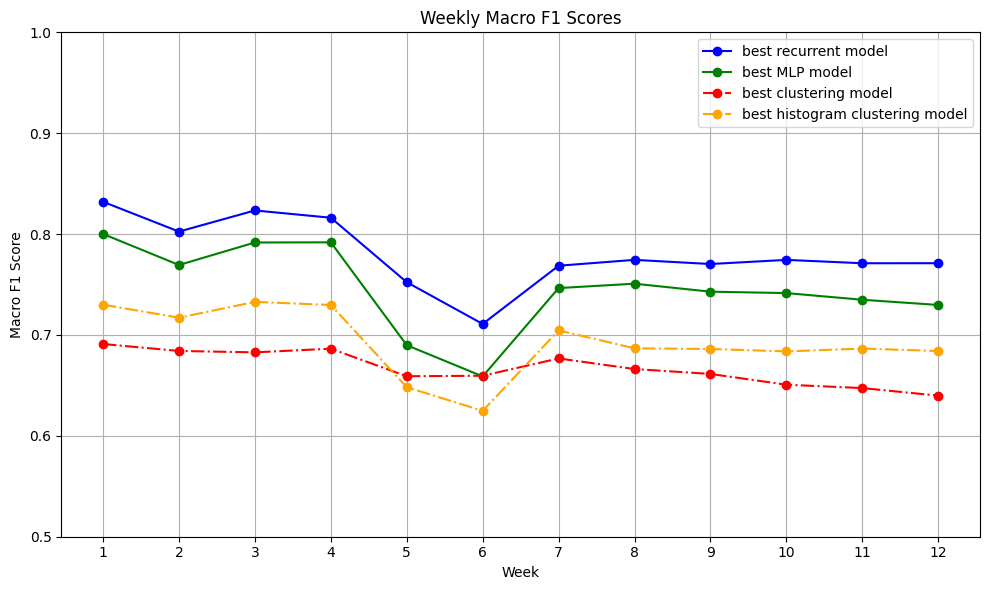

In [20]:
draw_weeks_graphs(week_scores_rnn,week_scores_mlp, week_scores_clustering, week_scores_histogram_clustering) 

# n_flows,n_packets,n_bytes

In [21]:
del test_data
test_data = np.load(test_data_path, allow_pickle=True)

# Define the subset of features you want to use for training
SELECTED_FEATURES = [
    "n_flows", "n_packets", "n_bytes" # ← change this list as needed
]

SELECTED_INDICES = [ALL_FEATURES.index(feat) for feat in SELECTED_FEATURES]
input_size = len(SELECTED_FEATURES)

In [22]:
best_rnn_model = LSTMClassifier(input_size=input_size, hidden_size=128, num_classes=num_classes,num_layers=3, dropout=0.5)
best_rnn_model.load_state_dict(torch.load(f"{rnn_models_path}/LSTM,128,adam,0.001,3,0.5,1024,log,n_flows,n_packets,n_bytes.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
best_mlp_model = MLPClassifier(5,256, input_dim = 42*len(SELECTED_FEATURES), activation_f = nn.Sigmoid(), dropout = 0.0)
best_mlp_model.load_state_dict(torch.load(f"{mlp_models_path}/MLP,256,adam,0.001,5,sigmoid,0.2,1024,log,n_flows,n_packets,n_bytes.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [24]:
cls = TsKmeansClassifier
cls = cls.from_pickle(f"models/2000;euclidean,n_flows,n_packets,n_bytes,True,log.pkl")

In [25]:
week_scores_rnn = evaluate_model_weekly(best_rnn_model,test_data,1024)
week_scores_mlp = evaluate_model_weekly(best_mlp_model,test_data,1024)
week_scores_clustering = evaluate_clustering_weekly(cls, test_data)

In [27]:
convert_dataset_to_histograms_inplace(test_data)
cls = TsKmeansClassifier
cls = cls.from_pickle(f"models/hist_1750;euclidean,n_flows,n_packets,n_bytes,True,log.pkl")
week_scores_histogram_clustering = evaluate_clustering_weekly(cls, test_data)

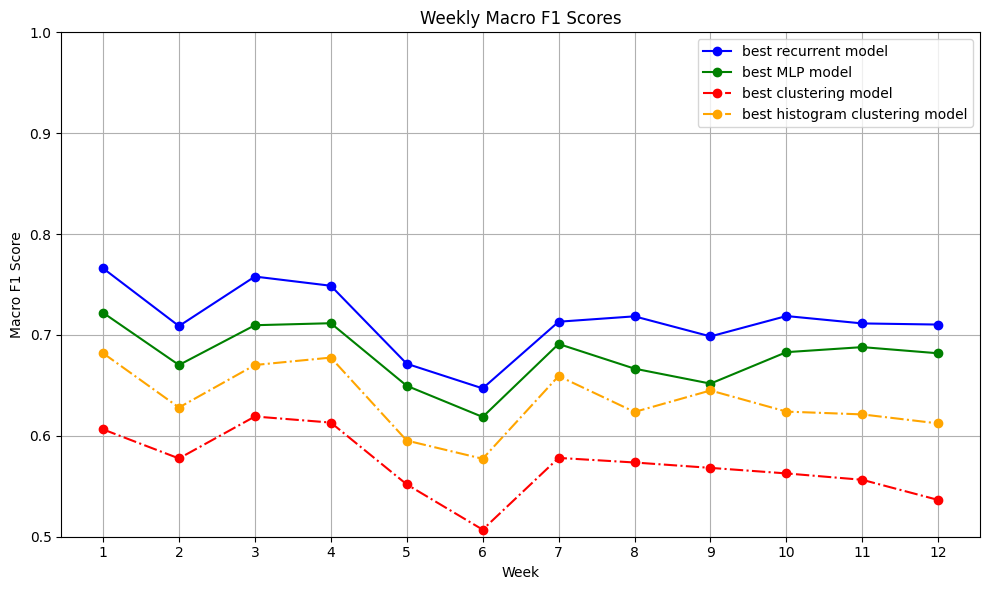

In [28]:
draw_weeks_graphs(week_scores_rnn,week_scores_mlp, week_scores_clustering, week_scores_histogram_clustering) 

# n_bytes,n_dest_ports,n_dest_ip,dir_ratio_bytes,avg_ttl

In [29]:
#del test_data
test_data = np.load(test_data_path, allow_pickle=True)

# Define the subset of features you want to use for training
SELECTED_FEATURES = [
    "n_bytes","n_dest_ports","n_dest_ip","dir_ratio_bytes","avg_ttl" # ← change this list as needed
]

SELECTED_INDICES = [ALL_FEATURES.index(feat) for feat in SELECTED_FEATURES]
input_size = len(SELECTED_FEATURES)

In [30]:
best_rnn_model = LSTMClassifier(input_size=input_size, hidden_size=128, num_classes=num_classes,num_layers=3, dropout=0.5)
best_rnn_model.load_state_dict(torch.load(f"{rnn_models_path}/LSTM,128,adam,0.001,3,0.5,256,log,n_bytes,n_dest_ports,n_dest_ip,dir_ratio_bytes,avg_ttl.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
best_mlp_model = MLPClassifier(4,1024, input_dim = 42*len(SELECTED_FEATURES), activation_f = nn.Sigmoid(), dropout = 0.0)
best_mlp_model.load_state_dict(torch.load(f"{mlp_models_path}/MLP,1024,adam,0.0001,4,sigmoid,0.0,256,log,n_bytes,n_dest_ports,n_dest_ip,dir_ratio_bytes,avg_ttl.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [32]:
cls = TsKmeansClassifier
cls = cls.from_pickle(f"models/1750;euclidean,n_bytes,n_dest_ports,n_dest_ip,dir_ratio_bytes,avg_ttl,True,log.pkl")

In [33]:
week_scores_clustering = evaluate_clustering_weekly(cls, test_data)

In [34]:
week_scores_rnn = evaluate_model_weekly(best_rnn_model,test_data,1024)
week_scores_mlp = evaluate_model_weekly(best_mlp_model,test_data,1024)

In [35]:
convert_dataset_to_histograms_inplace(test_data)
cls = TsKmeansClassifier
cls = cls.from_pickle(f"models/hist_2000;euclidean,n_bytes,n_dest_ports,n_dest_ip,dir_ratio_bytes,avg_ttl,True,log.pkl")
week_scores_histogram_clustering = evaluate_clustering_weekly(cls, test_data)

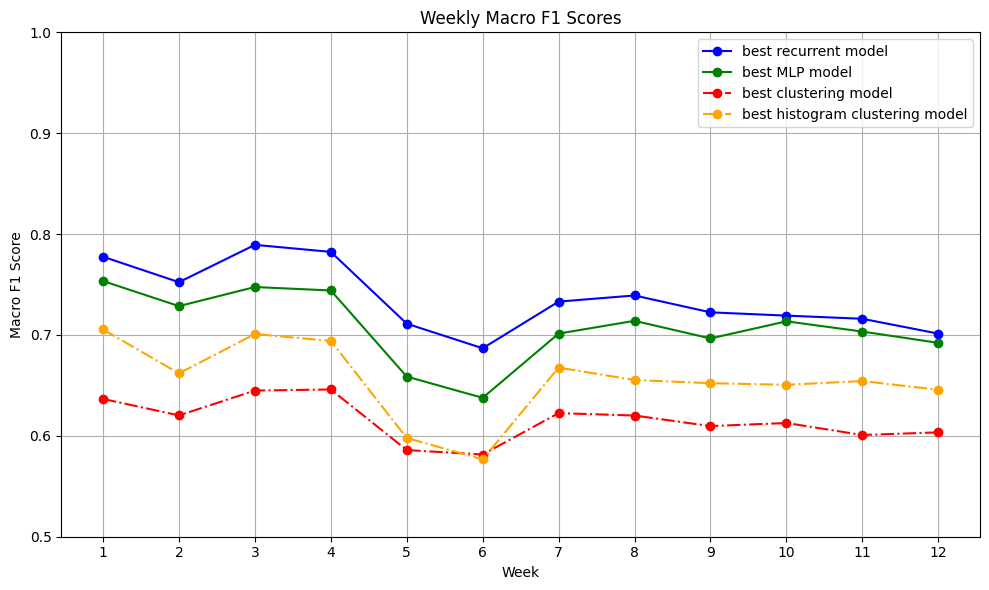

In [36]:
draw_weeks_graphs(week_scores_rnn,week_scores_mlp, week_scores_clustering, week_scores_histogram_clustering) 

# tcp_udp_ratio_bytes,dir_ratio_bytes,avg_duration,avg_ttl

In [37]:
del test_data
test_data = np.load(test_data_path, allow_pickle=True)

# Define the subset of features you want to use for training
SELECTED_FEATURES = [
    "tcp_udp_ratio_bytes","dir_ratio_bytes","avg_duration","avg_ttl" # ← change this list as needed
]

SELECTED_INDICES = [ALL_FEATURES.index(feat) for feat in SELECTED_FEATURES]
input_size = len(SELECTED_FEATURES)

In [38]:
best_rnn_model = LSTMClassifier(input_size=input_size, hidden_size=128, num_classes=num_classes,num_layers=3, dropout=0.5)
best_rnn_model.load_state_dict(torch.load(f"{rnn_models_path}/LSTM,128,adam,0.001,3,0.5,1024,log,tcp_udp_ratio_bytes,dir_ratio_bytes,avg_duration,avg_ttl.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [39]:
best_mlp_model = MLPClassifier(5,1024,input_dim = 42*len(SELECTED_FEATURES), activation_f = nn.Sigmoid(), dropout = 0.0)
best_mlp_model.load_state_dict(torch.load(f"{mlp_models_path}/MLP,1024,adam,0.0001,5,sigmoid,0.5,256,log,tcp_udp_ratio_bytes,dir_ratio_bytes,avg_duration,avg_ttl.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [40]:
week_scores_rnn = evaluate_model_weekly(best_rnn_model,test_data,1024)
week_scores_mlp = evaluate_model_weekly(best_mlp_model,test_data,1024)

In [41]:
cls = TsKmeansClassifier
cls = cls.from_pickle(f"models/2000;euclidean,tcp_udp_ratio_bytes,dir_ratio_bytes,avg_duration,avg_ttl,True,z_score.pkl")

In [42]:
test_data_path = "preprocessed_test_data_log/test_data_z.npy"
del test_data

In [43]:
test_data = np.load(test_data_path, allow_pickle=True)

In [44]:
week_scores_clustering = evaluate_clustering_weekly(cls, test_data)

In [46]:
convert_dataset_to_histograms_inplace(test_data)
cls = TsKmeansClassifier
cls = cls.from_pickle(f"models/hist_2000;euclidean,tcp_udp_ratio_bytes,dir_ratio_bytes,avg_duration,avg_ttl,True,z_score.pkl")
week_scores_histogram_clustering = evaluate_clustering_weekly(cls, test_data)

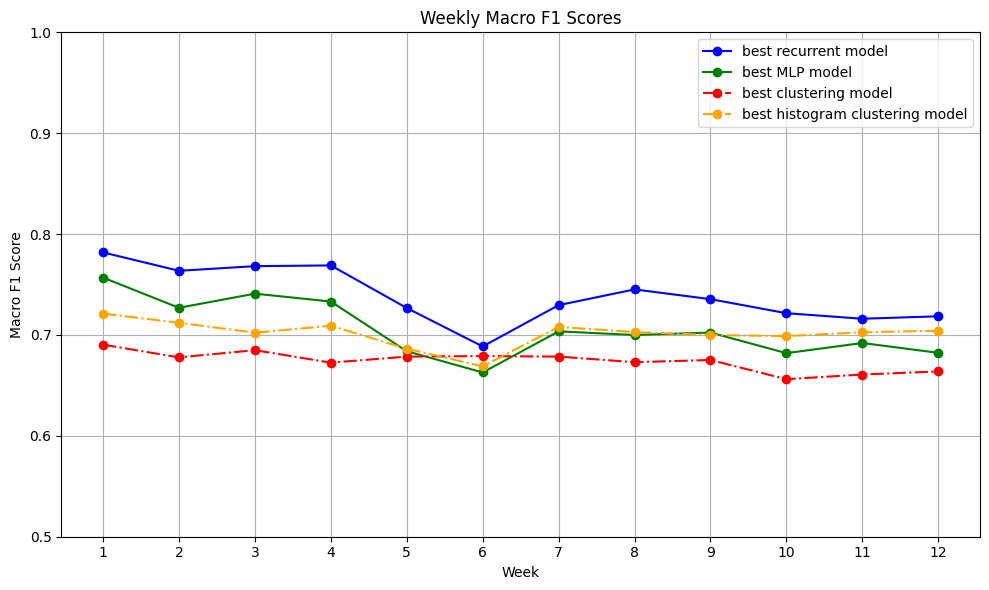

In [47]:
draw_weeks_graphs(week_scores_rnn,week_scores_mlp, week_scores_clustering, week_scores_histogram_clustering) 